<h2 
    align="center" 
    style="font-size: 40px; border-bottom: 2px solid black; border-top: 2px solid black; padding: 30px 0;">
    Goal
</h2>

Classification problem

<strong>
The goal is to predict if the client will subscribe to a term deposit or not.
    
>>
For more info, follow this [link](https://archive.ics.uci.edu/dataset/222/bank+marketing)

<h2 
    align="center" 
    style="font-size: 40px; border-bottom: 2px solid black; border-top: 2px solid black; padding: 30px 0;">
    Import Libraries
</h2>

In [1]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score, auc, roc_curve, make_scorer
from sklearn.preprocessing import KBinsDiscretizer, OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.feature_selection import mutual_info_classif
from lime.lime_tabular import LimeTabularExplainer
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import make_pipeline
from bokeh.models import ColumnDataSource
from sklearn.impute import SimpleImputer
from scipy.stats import shapiro, kstest
from imblearn.combine import SMOTEENN
from pycaret.classification import *
from bokeh.io import output_notebook
from ucimlrepo import fetch_ucirepo
from bokeh.layouts import gridplot
import scipy.stats.stats as stats
import matplotlib.pyplot as plt
from joblib import dump, load
import bokeh.plotting as bp
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import traceback
import string
import dtale
import shap
import re

pd.set_option('display.max_columns', None)

<h2 
    align="center" 
    style="font-size: 40px; border-bottom: 2px solid black; border-top: 2px solid black; padding: 30px 0;">
    Load Data
</h2>

In [2]:
# fetch dataset
bank_marketing = fetch_ucirepo(id=222)

In [3]:
# data (as pandas dataframes) 
X = bank_marketing.data.features
y = bank_marketing.data.targets

In [4]:
# merge X and y variables and name the 'y' column in the new df as 'target'
Xy = pd.merge(X, y, left_index=True, right_index=True).rename(columns={'y': 'target'})

In [5]:
Xy.sample(2)

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,target
1522,44,blue-collar,married,secondary,no,373,yes,no,NaN,8,may,122,2,-1,0,NaN,no
1341,50,services,divorced,secondary,no,145,yes,no,NaN,8,may,170,1,-1,0,NaN,no


<h2 
    align="center" 
    style="font-size: 40px; border-bottom: 2px solid black; border-top: 2px solid black; padding: 30px 0;">
    Exploratory Data Analysis - EDA
</h2>

In [6]:
# Detail EDA using dtale library
d = dtale.show(Xy)
print(d.main_url)

<bound method DtaleData.main_url of >


In [7]:
# check variable types
Xy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     8252 non-null   object
 16  target       45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [8]:
Xy.describe()

,age,balance,day_of_week,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


<h2 
    align="center" 
    style="font-size: 40px; border-bottom: 2px solid black; border-top: 2px solid black; padding: 30px 0;">
    Data Cleaning
</h2>

<h2 style="font-size: 20px; margin: 20px 0; border-bottom: 2px solid black; padding: 15px 0;">
    <strong></i>
        1. Convert text to lower case  and remove extra spaces
    </i></strong>
</h2>

In [9]:
#1a. Function to convert texts to lowercases and strip extra spaces
def process_text(value):
    if isinstance(value, str):
        return value.lower().strip()
    else:
        return value

In [10]:
#1b. Apply the function to each element of the DataFrame
Xy = Xy.map(process_text)

In [11]:
Xy.sample(1)

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,target
31160,35,technician,divorced,secondary,no,2823,yes,no,cellular,26,feb,74,1,24,1,failure,no


<h2 style="font-size: 20px; margin: 20px 0; border-bottom: 2px solid black; padding: 15px 0;">
    <strong></i>
        2. Remove duplicated rows and empty rows/columns
    </i></strong>
</h2>

In [12]:
#2a. remove duplicate rows based on all columns and reset the index to ensure a clean and continuous integer index

sh1 = Xy.shape
# remove duplicate rows
Xy = Xy.drop_duplicates()

# reset the index
Xy = Xy.reset_index(drop=True)

sh2 = Xy.shape
print(f'shape_before: {sh1}, \n shape_after: {sh2}')

shape_before: (45211, 17), 
 shape_after: (45211, 17)


In [13]:
#2b. Check if any column has all values as None (NaN) and delete the identified columns if any

sh1 = Xy.shape
# Check column for NaN values
columns_to_delete = Xy.columns[Xy.isnull().all()]

# Delete the identified columns
Xy = Xy.drop(columns=columns_to_delete)

sh1 = Xy.shape
print(f'shape_before: {sh1}, \n shape_after: {sh2}')

shape_before: (45211, 17), 
 shape_after: (45211, 17)


<h2 style="font-size: 20px; margin: 20px 0; border-bottom: 2px solid black; padding: 15px 0;">
    <strong></i>
        3. Examine the Data
    </i></strong>
</h2>

In [14]:
#3a. function to count and list total number of unique values in each column of Xy
def generate_column_summary(df, num_examples=3):
    '''
    Generate a summary DataFrame with information about each column in the input DataFrame.
    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - num_examples (int): Number of unique examples to show for each column.
    Returns:
    - pd.DataFrame: Summary DataFrame containing columns:
        - 'Column Name': Name of each column.
        - 'Data Type': Data type of each column.
        - 'Unique Values': Total number of unique values in each column.
        - 'Examples': Unique examples for each column as a list of tuples.
    '''
    # Initialize an empty DataFrame
    summary_df = pd.DataFrame(columns=['Column_Name', 'Unique_Count', 'Data_Type', 'Examples'])

    # Iterate through each column in the input DataFrame
    for column in df.columns:
        # Get data type of the column
        data_type = df[column].dtype

        # Get the total number of unique values in the column
        num_unique_values = df[column].nunique()

        # Get unique examples from the column as a list
        unique_examples = df[column].unique()[:num_examples]

        # Append the new information for each column
        summary_df = pd.concat([summary_df, pd.DataFrame({
            'Column_Name': [column],
            'Unique_Count': [num_unique_values],
            'Data_Type': [data_type],
            'Examples': [list(unique_examples)]
        })], ignore_index=True)
        
    return summary_df

In [15]:
#3b. see results of unique values in Xy with example
summary_df = generate_column_summary(Xy, num_examples=3)
print(summary_df.sort_values(by='Unique_Count', ascending=True))

    Column_Name Unique_Count Data_Type                                Examples
8       contact            2    object              [nan, cellular, telephone]
7          loan            2    object                               [no, yes]
6       housing            2    object                               [yes, no]
4       default            2    object                               [no, yes]
16       target            2    object                               [no, yes]
2       marital            3    object             [married, single, divorced]
15     poutcome            3    object                   [nan, failure, other]
3     education            3    object              [tertiary, secondary, nan]
1           job           11    object  [management, technician, entrepreneur]
10        month           12    object                         [may, jun, jul]
9   day_of_week           31     int64                               [5, 6, 7]
14     previous           41     int64              

<h2 style="font-size: 20px; margin: 20px 0; border-bottom: 2px solid black; padding: 15px 0;">
    <strong></i>
        4. Check for Missing Values
    </i></strong>
</h2>

In [16]:
#4a. function to summarize missing values in a df
def check_missing(df):
    '''
    This function checks for missing values in each column of a DataFrame and returns only those columns
    that have missing data, along with the total count and percentage of missing data.
    '''
    
    # Calculate total missing values and percentage missing for each column
    total_missing = df.isnull().sum().sort_values(ascending=False)
    percentage = (df.isnull().mean() * 100).round(2).sort_values(ascending=False)
    
    # Combine total missing values and percentage missing into a single DataFrame
    missing_data = pd.concat([total_missing, percentage], axis=1, keys=['TotalMissing', 'PercentMissing'])
    
    # Filter out columns that have no missing data
    missing_data = missing_data[missing_data['TotalMissing'] > 0]
    
    return missing_data

In [17]:
#4b. show missing value information
check_missing(Xy)

,TotalMissing,PercentMissing
poutcome,36959,81.75
contact,13020,28.80
education,1857,4.11
job,288,0.64


<h2 style="font-size: 20px; margin: 20px 0; border-bottom: 2px solid black; padding: 15px 0;">
    <strong></i>
        5. Temporal Fix for Missing Values
    </i></strong>
</h2>

In [18]:
#5a. inspect the curent unique categories in the data set

# lists of unique values in Xy df
poutcome_v = ['nan', 'failure', 'other', 'success']
contact_v = ['nan', 'cellular', 'telephone']
education_v = ['tertiary', 'secondary', 'nan', 'primary']
job_v = ['management', 'technician', 'entrepreneur', 'blue-collar', 'nan','retired', 
              'admin.', 'services', 'self-employed', 'unemployed', 'housemaid', 'student']

# list of expected unique values of Xy downloaded from: https://archive.ics.uci.edu/dataset/222/bank+marketing
poutcome_e = ['failure', 'nonexistent', 'success']
contact_e = ['cellular', 'telephone']
education_e = ['basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate', 
                    'professional.course','university.degree','unknown']
job_e = ['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 
              'self-employed', 'services','student','technician','unemployed','unknown']

In [19]:
#5b. fill the poutcome category using placeholder
## poutcome: outcome of the previous marketing campaign
## 3 unique values is expected but we have 3+missing_values

# apply placeholder - nonexistent
Xy['poutcome'] = Xy.poutcome.replace('', 'nonexistent').replace('other', 'nonexistent').fillna('nonexistent')

In [20]:
#5c. fill the contact category using mode
## contact: communication type
## 2 unique values is expected but we have 2+missingvalues

# find the mode
mode_value = Xy['contact'].mode()[0]

# apply the mode
Xy['contact'] = Xy['contact'].fillna(mode_value)

In [21]:
#5d. fill the education category using placeholder
## education: level of education
## list is not consistent

# apply placeholder - nonexistent
Xy['education'] = Xy.education.replace('', 'unknown').fillna('unknown')

In [22]:
#5e. fill the contact category using placeholder
## job: occupation type
## 12 unique values is expected but we have 11+missingvalues

# apply placeholder - unknown
Xy['job'] = Xy.job.replace('', 'unknown').fillna('unknown')

In [23]:
#5f. check again for missing value
check_missing(Xy)

,TotalMissing,PercentMissing


In [24]:
#5g. drop columns with too many (>20 percent) missing values

Xy = Xy.dropna(axis=1, thresh=int(0.80*len(Xy)))
Xy.shape

(45211, 17)

<h2 style="font-size: 20px; margin: 20px 0; border-bottom: 2px solid black; padding: 15px 0;">
    <strong></i>
        6. Convert the Dependent Variable to Binary
    </i></strong>
</h2>

In [25]:
#5a. Encode the dependent variable to binary 1s & 0s
Xy['target'] = Xy['target'].apply(lambda x : 1 if x == 'yes' else 0)

In [26]:
#5b. see results of unique values in target variable with example
summary_df = generate_column_summary(Xy, num_examples=3)
print(summary_df[-1:])

   Column_Name Unique_Count Data_Type Examples
16      target            2     int64   [0, 1]


<h2 
    align="center" 
    style="font-size: 40px; border-bottom: 2px solid black; border-top: 2px solid black; padding: 30px 0;">
    Base Model I - Raw
</h2>

<h2 style="font-size: 20px; margin: 20px 0; border-bottom: 2px solid black; padding: 15px 0;">
    <strong></i>
        1. Prepare the Base Dataset
    </i></strong>
</h2>

In [27]:
# create a copy of original dataset
Xy_base = Xy.copy()

# apply label encoder to all categorical columns
label_encoder = LabelEncoder()
categorical_columns = Xy_base.select_dtypes(include=['object', 'category']).columns
Xy_base[categorical_columns] = Xy_base[categorical_columns].apply(lambda col: label_encoder.fit_transform(col))

# view sample new Xy_base df
Xy_base.sample(3)

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,target
32339,35,1,1,0,0,4319,0,0,0,16,0,266,1,-1,0,1,0
37227,33,7,1,1,0,107,1,1,0,13,8,21,6,-1,0,1,0
43213,73,5,2,1,0,1050,0,0,0,4,7,562,3,181,2,0,1


<h2 style="font-size: 20px; margin: 20px 0; border-bottom: 2px solid black; padding: 15px 0;">
    <strong></i>
        2. Pycaret Base Models
    </i></strong>
</h2>

In [28]:
# split training, validating, and testing datasets
Xy_base_train_val = Xy_base.sample(frac=0.70, random_state=0)
Xy_base_test = Xy_base.drop(Xy_base_train_val.index)

# view split shapes
print("Xy_base_train_val shape:", Xy_base_train_val.shape, "Xy_base_test shape:", Xy_base_test.shape)

Xy_base_train_val shape: (31648, 17) Xy_base_test shape: (13563, 17)


In [29]:
# initialize PyCaret setup for classification - without preprocess
clf_setup = setup(data=Xy_base_train_val, target='target', train_size=0.75, preprocess=False, session_id=0)

,Description,Value
0,Session id,0
1,Target,target
2,Target type,Binary
3,Original data shape,"(31648, 17)"
4,Transformed data shape,"(31648, 17)"
5,Transformed train set shape,"(23736, 17)"
6,Transformed test set shape,"(7912, 17)"
7,Numeric features,16


In [30]:
# compare models base on precision TP/(TP+FP):
best_model = compare_models(sort='Precision')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.8916,0.0000,0.1489,0.6411,0.2413,0.2067,0.2725,0.0130
et,Extra Trees Classifier,0.8982,0.9075,0.2910,0.6333,0.3984,0.3510,0.3831,0.5010
rf,Random Forest Classifier,0.9013,0.9139,0.3563,0.6328,0.4556,0.4060,0.4264,0.5800
gbc,Gradient Boosting Classifier,0.9007,0.9104,0.3494,0.6319,0.4495,0.3999,0.4214,0.7450
lightgbm,Light Gradient Boosting Machine,0.9017,0.9201,0.4047,0.6170,0.4884,0.4367,0.4487,0.2490
catboost,CatBoost Classifier,0.9012,0.9228,0.4047,0.6126,0.4871,0.4350,0.4466,5.3450
ada,Ada Boost Classifier,0.8969,0.8952,0.3258,0.6034,0.4227,0.3716,0.3932,0.2170
xgboost,Extreme Gradient Boosting,0.8993,0.9111,0.4196,0.5941,0.4913,0.4373,0.4457,0.2100
lda,Linear Discriminant Analysis,0.8950,0.8587,0.3578,0.5763,0.4412,0.3868,0.4003,0.0190
lr,Logistic Regression,0.8897,0.8369,0.2056,0.5684,0.3018,0.2559,0.2955,1.4100


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [31]:
# view best model based on precision
print(best_model)

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, positive=False, random_state=0, solver='auto',
                tol=0.0001)


In [32]:
# train the best model on the entire train (Xy_base_train_val) dataset
final_model = finalize_model(best_model)

In [33]:
# make predictions using the best model on the testing set
predictions_test = predict_model(final_model, data=Xy_base_test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ridge Classifier,0.8928,0.5841,0.1785,0.6998,0.2844,0.2480,0.3172


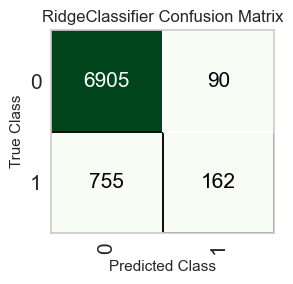

In [34]:
# Visualize the confusion matrix
plt.figure(figsize=(3, 3))
plot_model(final_model, plot='confusion_matrix')

<h2 
    align="center" 
    style="font-size: 40px; border-bottom: 2px solid black; border-top: 2px solid black; padding: 30px 0;">
    Feature Analysis
</h2>

<h2 style="font-size: 20px; margin: 20px 0; border-bottom: 2px solid black; padding: 15px 0;">
    <strong></i>
        1. Feature Importance Metrics
    </i></strong>
</h2>

In [35]:
#1a. using Random Forest Classifier in pycaret
model_rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9006,0.9129,0.3345,0.6345,0.4381,0.3892,0.4133
1,0.8985,0.9170,0.3382,0.6118,0.4356,0.3849,0.4054
2,0.8951,0.8999,0.3564,0.5765,0.4404,0.3861,0.3997
3,0.9048,0.9196,0.3732,0.6603,0.4769,0.4289,0.4501
4,0.8981,0.9095,0.3478,0.6076,0.4424,0.3908,0.4093
5,0.9052,0.9145,0.3986,0.6509,0.4944,0.4454,0.4618
6,0.9018,0.9197,0.3455,0.6419,0.4492,0.4006,0.4238
7,0.9022,0.9165,0.3345,0.6525,0.4423,0.3948,0.4213
8,0.8989,0.9104,0.3527,0.6101,0.4470,0.3957,0.4137


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [36]:
#1b. train Random Forest on the entire train (Xy_base_train_val) dataset
final_rf = finalize_model(model_rf)

In [37]:
#1c. make predictions using the final trained Random Forest on the testing set
predictions_test = predict_model(final_rf, data=Xy_base_test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9042,0.9231,0.3941,0.6667,0.4953,0.4462,0.4651


In [38]:
#1d. get feature importance from Random Forest
feature_importance_scores = final_rf.feature_importances_
print(feature_importance_scores)

[0.10578343 0.04889827 0.02284283 0.02773036 0.00174311 0.11461653
 0.02353506 0.00975374 0.00768084 0.0918555  0.08793639 0.28006673
 0.04014346 0.04978008 0.02313114 0.06450254]


In [39]:
#1e. get feature names
feature_names = Xy_base_train_val.drop(columns=['target']).columns.tolist()
#feature_names = final_rf.feature_names_out_

# put it in df
FI_df = pd.DataFrame({'Features': feature_names, 'FI': feature_importance_scores})

# sort feature importances
FI_sorted = FI_df.sort_values(by='FI', ascending=False)

print(FI_sorted)

       Features        FI
11     duration  0.280067
5       balance  0.114617
0           age  0.105783
9   day_of_week  0.091856
10        month  0.087936
15     poutcome  0.064503
13        pdays  0.049780
1           job  0.048898
12     campaign  0.040143
3     education  0.027730
6       housing  0.023535
14     previous  0.023131
2       marital  0.022843
7          loan  0.009754
8       contact  0.007681
4       default  0.001743


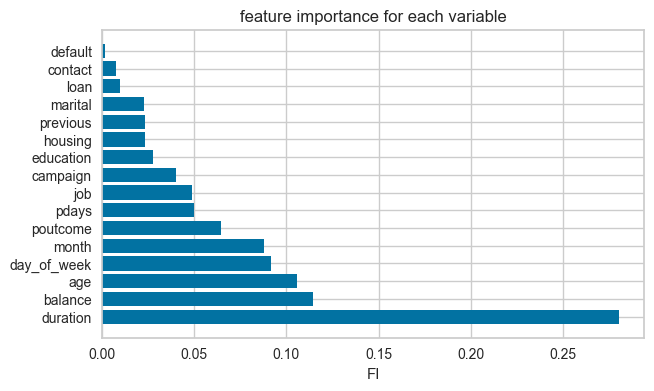

In [40]:
#1f. visualize FI
plt.figure(figsize=(7, 4))
plt.barh(FI_sorted['Features'], FI_sorted['FI'])
plt.xlabel('FI')
plt.title('feature importance for each variable');

<h2 style="font-size: 20px; margin: 20px 0; border-bottom: 2px solid black; padding: 15px 0;">
    <strong>
        </i>2. Information Value Metrics</i>
        <a href="https://sundarstyles89.medium.com/weight-of-evidence-and-information-value-using-python-6f05072e83eb" target="_blank">[code]</a>
    </strong>
</h2>

In [41]:
#2a. create a copy of original dataset for IV scores
Xy_IV = Xy.copy()

In [42]:
# 2b. function to compute IV and WOE
## REF: check link above

max_bin = 20
force_bin = 3
# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin
        
        #bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        # np.linspace(0, 1, n) creates an array of n quantiles between 0 and 1
        quantiles_to_compute = np.linspace(0, 1, n)
        # Use the .quantile() method to compute these quantiles on the 'X' column
        bins = notmiss['X'].quantile(quantiles_to_compute)
        
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["Features"] = "VAR"
    d3 = d3[['Features','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["Features"] = "VAR"
    d3 = d3[['Features','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(pd.Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["Features"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["Features"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                #iv_df = iv_df.append(conv,ignore_index=True)
                iv_df = pd.concat([iv_df, conv], ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('Features').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [43]:
#12. compute the weight of evidence and information value
final_iv, iv = data_vars(Xy_IV, Xy_IV.target)

# # display information value
# print(iv.round(4))

In [44]:
#2c. Label each category of IV

# create labels
iv_categories = ['WeakPredictor', 'SuspiciousPredictor', 'LowPredictor', 'MediumPredictor', 'StrongPredictor']

# add a new column for IV labels to the DataFrame
iv['IV_Labels'] = pd.cut(iv['IV'], bins=[-np.inf, 0.02, 0.1, 0.3, 0.5, np.inf], labels=iv_categories, right=False)

# sort the df by IV
iv_sorted = iv.sort_values(by='IV', ascending=False)

# display the modified DataFrame with the new IV labels column
print(f'DataFrame with IV Labels: \n')
print(iv_sorted)

DataFrame with IV Labels: 

       Features        IV            IV_Labels
6      duration  1.634617      StrongPredictor
14     poutcome  0.493501      MediumPredictor
12        month  0.436131      MediumPredictor
13        pdays  0.219604         LowPredictor
8       housing  0.188681         LowPredictor
9           job  0.155697         LowPredictor
15     previous  0.153206         LowPredictor
1       balance  0.104046         LowPredictor
10         loan  0.054859  SuspiciousPredictor
7     education  0.050112  SuspiciousPredictor
2      campaign  0.043961  SuspiciousPredictor
11      marital  0.040127  SuspiciousPredictor
4   day_of_week  0.017486        WeakPredictor
5       default  0.006256        WeakPredictor
0           age  0.002145        WeakPredictor
3       contact  0.001806        WeakPredictor


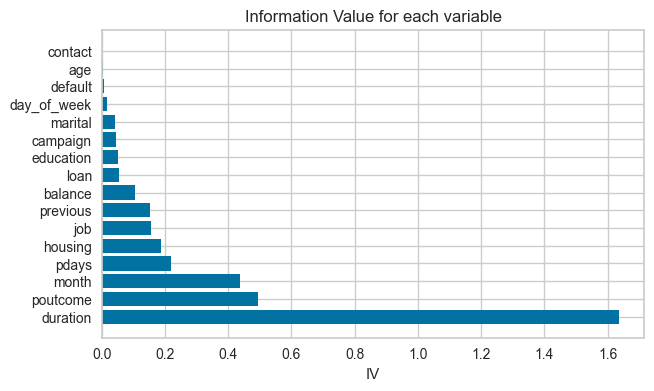

In [45]:
#2d. visualize IV
plt.figure(figsize=(7, 4))
plt.barh(iv_sorted['Features'], iv_sorted['IV'])
plt.xlabel('IV')
plt.title('Information Value for each variable');

<h2 style="font-size: 20px; margin: 20px 0; border-bottom: 2px solid black; padding: 15px 0;">
    <strong></i>
        3. Mutual Information Metrics
    </i></strong>
</h2>

In [46]:
#3a. label encode the categorical data types in the features
# create a copy of original dataset for MI scores
Xy_MI = Xy.copy()
X_mi = Xy_MI.drop('target', axis=1)
y_mi = Xy_MI.target

# apply label encoder to all categorical columns
label_encoder = LabelEncoder()
categorical_columns = X_mi.select_dtypes(include=['object', 'category']).columns
X_mi[categorical_columns] = X_mi[categorical_columns].apply(lambda col: label_encoder.fit_transform(col))

In [47]:
#3b. compute mutual information scores
## Features with higher mutual information values are considered more informative for predicting the target variable

# compute MI
mi_scores = mutual_info_classif(X_mi, y_mi)

# arrange the MI scores into a DataFrame
mi_df = pd.DataFrame({'Features': X_mi.columns, 'MI_scores': mi_scores})

# sort the df by IV
mi_sorted = mi_df.sort_values(by='MI_scores', ascending=False)

# # display the DataFrame
# print(mi_sorted)

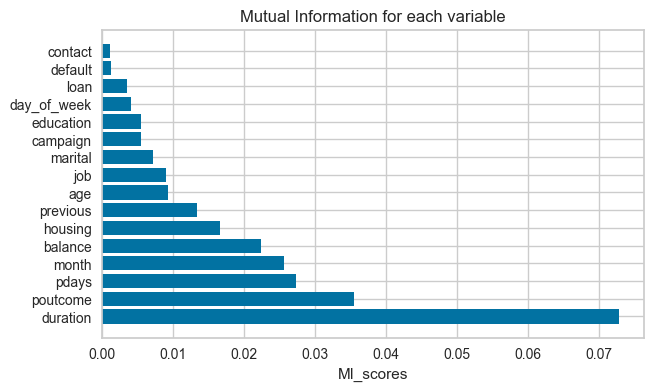

In [48]:
#3c. visualize MI
plt.figure(figsize=(7, 4))
plt.barh(mi_sorted['Features'], mi_sorted['MI_scores'])
plt.xlabel('MI_scores')
plt.title('Mutual Information for each variable');

<h2 style="font-size: 20px; margin: 20px 0; border-bottom: 2px solid black; padding: 15px 0;">
    <strong></i>
        4. Point-Biserial Correlation Coefficients Metrics
    </i></strong>
</h2>

In [49]:
#4a. label encode the categorical data types in the features
# create a copy of original dataset for correlation computation
Xy_corr = Xy.copy()

# apply label encoder to all categorical columns
label_encoder = LabelEncoder()
categorical_columns = Xy_corr.select_dtypes(include=['object', 'category']).columns
Xy_corr[categorical_columns] = Xy_corr[categorical_columns].apply(lambda col: label_encoder.fit_transform(col))

In [50]:
#4b. compute point-biserial correlation to identify features with strong correlations (+ve/-ve) with the target variable
## point-biserial compute both correlation and statistical significance (p-value)

# extract the target binary variable
binary_variable = Xy_corr['target']

# Create empty lists to store results
features = []
correlation_coefficients = []
p_values = []

# compute correlation coefficient of features w.r.t target variable using point-biserial
for feature in Xy_corr.columns:
    # Skip the target variable
    if feature == 'target':
        continue
    
    # extract the current feature
    continuous_variable = Xy_corr[feature]
    
    # compute point-biserial correlation coefficient
    r_pb, p_value = stats.pointbiserialr(binary_variable, continuous_variable)
    
    # store results in lists
    features.append(feature)
    correlation_coefficients.append(r_pb)
    p_values.append(p_value)

# create DataFrame from lists
pb_corr_df = pd.DataFrame({'Features': features, 'PointBiserial_corr': correlation_coefficients, 'P-value': p_values})

# absolute values of correlation coefficients for visualization
pb_corr_df['PointBiserial_corr'] = pb_corr_df['PointBiserial_corr'].abs()

##NOTE:
# pearsonr is used for analyzing the correlation between two continuous variables
# pointbiserialr is used for analyzing the correlation between a binary variable and a continuous variable

In [51]:
#4c. sort the df and use hypothesis testing to determine if the observed correlations are statistically significant
## correlation coefficients close to +1 or -1 indicate strong linear relationships, 0 indicate weak or no linear relationship
## if p-value < 0.05, reject null hypothesis, there is evidence of a significant correlation between the target and features

pb_corr_sorted = pb_corr_df.sort_values(by='PointBiserial_corr', ascending=False)
print(pb_corr_sorted)

       Features  PointBiserial_corr        P-value
11     duration            0.394521   0.000000e+00
15     poutcome            0.141081  1.137841e-199
6       housing            0.139173  2.621927e-194
13        pdays            0.103621  3.790553e-108
14     previous            0.093236   7.801830e-88
12     campaign            0.073172   1.012347e-54
7          loan            0.068185   9.793658e-48
3     education            0.066241   3.811335e-45
5       balance            0.052838   2.521114e-29
2       marital            0.045588   3.074847e-22
1           job            0.040438   7.863489e-18
9   day_of_week            0.028348   1.653880e-09
0           age            0.025155   8.825644e-08
10        month            0.024471   1.950782e-07
4       default            0.022419   1.866327e-06
8       contact            0.014042   2.827466e-03


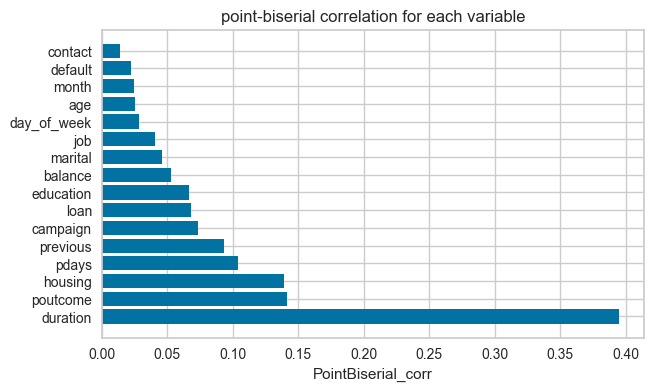

In [52]:
#4d. visualize MI
plt.figure(figsize=(7, 4))
plt.barh(pb_corr_sorted['Features'], pb_corr_sorted['PointBiserial_corr'])
plt.xlabel('PointBiserial_corr')
plt.title('point-biserial correlation for each variable');

<h2 style="font-size: 20px; margin: 20px 0; border-bottom: 2px solid black; padding: 15px 0;">
    <strong></i>
        5. Compare Feature Metrics
    </i></strong>
</h2>

In [53]:
#5a. combine all the feature importance metrics to one df

# merge FI_sorted, iv_sorted, mi_sorted, and pb_corr_sorted on the 'Features' column
combined_df = (pd.merge(iv_sorted, pb_corr_sorted, on='Features')
               .merge(FI_sorted, on='Features')
               .merge(mi_sorted, on='Features'))

# remove unwanted columns
combined_df = combined_df.drop(['IV_Labels', 'P-value'], axis=1)

# Rename columns for clarity
combined_df.columns = ['Features', 'IV', 'PB_Corr', 'FI', 'MI']

# Display the combined DataFrame
print(combined_df)

       Features        IV   PB_Corr        FI        MI
0      duration  1.634617  0.394521  0.280067  0.072697
1      poutcome  0.493501  0.141081  0.064503  0.035516
2         month  0.436131  0.024471  0.087936  0.025593
3         pdays  0.219604  0.103621  0.049780  0.027352
4       housing  0.188681  0.139173  0.023535  0.016649
5           job  0.155697  0.040438  0.048898  0.009060
6      previous  0.153206  0.093236  0.023131  0.013358
7       balance  0.104046  0.052838  0.114617  0.022370
8          loan  0.054859  0.068185  0.009754  0.003534
9     education  0.050112  0.066241  0.027730  0.005477
10     campaign  0.043961  0.073172  0.040143  0.005552
11      marital  0.040127  0.045588  0.022843  0.007241
12  day_of_week  0.017486  0.028348  0.091856  0.004111
13      default  0.006256  0.022419  0.001743  0.001352
14          age  0.002145  0.025155  0.105783  0.009240
15      contact  0.001806  0.014042  0.007681  0.001187


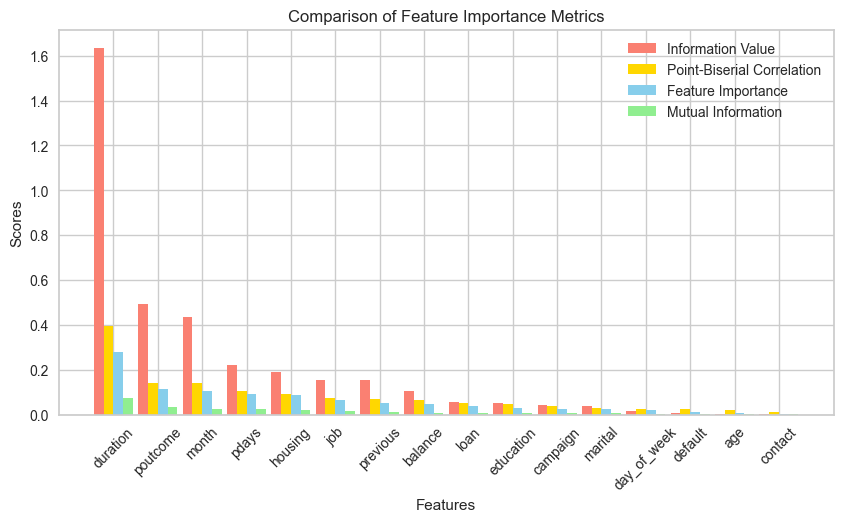

In [54]:
#5b. compare all the feature assessment metrix using a single histogram plot

# create figure and axis
fig, ax = plt.subplots(figsize=(10, 5))
bar_width = 0.22

# Create an array of indices for positioning the bars
x = np.arange(len(combined_df))

# plot iv_sorted
ax.bar(x - 1.5 * bar_width, iv_sorted['IV'], width=bar_width, label='Information Value', color='salmon')

# plot pb_corr_sorted
ax.bar(x - 0.5 * bar_width, pb_corr_sorted['PointBiserial_corr'], width=bar_width, label='Point-Biserial Correlation', color='gold')

# plot FI_sorted
ax.bar(x + 0.5 * bar_width, FI_sorted['FI'], width=bar_width, label='Feature Importance', color='skyblue')

# plot mi_sorted
ax.bar(x + 1.5 * bar_width, mi_sorted['MI_scores'], width=bar_width, label='Mutual Information', color='lightgreen')

# Set labels, title, and legend
ax.set_xlabel('Features')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Feature Importance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(combined_df['Features'], rotation=45)
ax.legend();

<h2 style="font-size: 20px; margin: 20px 0; border-bottom: 2px solid black; padding: 15px 0;">
    <strong></i>
        6. Summary
    </i></strong>
</h2>

In [55]:
#6a. the top best 9 features for prediction include:
print(combined_df.head(9))

   Features        IV   PB_Corr        FI        MI
0  duration  1.634617  0.394521  0.280067  0.072697
1  poutcome  0.493501  0.141081  0.064503  0.035516
2     month  0.436131  0.024471  0.087936  0.025593
3     pdays  0.219604  0.103621  0.049780  0.027352
4   housing  0.188681  0.139173  0.023535  0.016649
5       job  0.155697  0.040438  0.048898  0.009060
6  previous  0.153206  0.093236  0.023131  0.013358
7   balance  0.104046  0.052838  0.114617  0.022370
8      loan  0.054859  0.068185  0.009754  0.003534


<h2 
    align="center" 
    style="font-size: 40px; border-bottom: 2px solid black; border-top: 2px solid black; padding: 30px 0;">
    Avoid Data Leakage - Split Data
</h2>

<h2 style="font-size: 20px; margin: 20px 0; border-bottom: 2px solid black; padding: 15px 0;">
    <strong></i>
        1. Check Target Distribution for Imbalance
    </i></strong>
</h2>

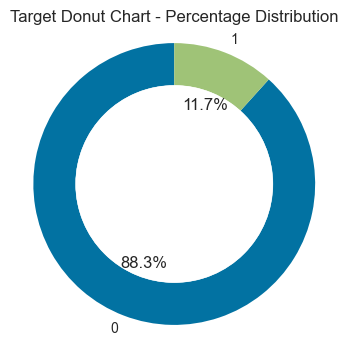

In [56]:
#1a. visualize the distribution of target variable to check for imbalance

# count each unique value in target variable
unique_ids = Xy['target'].unique()
counts_tgt = Xy['target'].value_counts()

# calculate percentages
percentages_tgt = (counts_tgt / len(Xy['target'])) * 100

# plot donut chart
fig, ax = plt.subplots(figsize = (4, 4))
ax.pie(percentages_tgt, labels=percentages_tgt.index, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.3))
ax.axis('equal')  # equal aspect ratio ensures the pie chart is circular.

# add a circle to create a donut chart
centre_circle = plt.Circle((0, 0), 0.7, color='white')
ax.add_patch(centre_circle)

# title of the chart
plt.title('Target Donut Chart - Percentage Distribution');

<h2 style="font-size: 20px; margin: 20px 0; border-bottom: 2px solid black; padding: 15px 0;">
    <strong></i>
        2. Train {80of100} | Validation {25of80} | Test Splits {20of100}
    </i></strong>
</h2>

In [57]:
#2a. train test split with stratify
Xy_train_val, Xy_test = train_test_split(Xy, test_size=0.20, random_state=1, stratify=Xy['target'])

print(f'Xy_train_val shape: {Xy_train_val.shape}, Xy_test shape: {Xy_test.shape}')

Xy_train_val shape: (36168, 17), Xy_test shape: (9043, 17)


In [58]:
#2b. percentage distribution of target variable in splits data

# percentage of 'target' variable in the original dataset Xy
original_class_distribution = Xy['target'].value_counts(normalize=True) * 100

# percentage of 'target' variable in the training set Xy_train_val
train_class_distribution = Xy_train_val['target'].value_counts(normalize=True) * 100

# percentage of 'target' variable in the test set Xy_test
test_class_distribution = Xy_test['target'].value_counts(normalize=True) * 100

# display the result in df
results_df = pd.DataFrame({
    'Original': original_class_distribution,
    'TrainingSet': train_class_distribution,
    'TestSet': test_class_distribution})
print(f'% of 0s and 1s in the split dataset are: \n\n {results_df.T}')

% of 0s and 1s in the split dataset are: 

 target               0          1
Original     88.301520  11.698480
TrainingSet  88.301814  11.698186
TestSet      88.300343  11.699657


<h2 
    align="center" 
    style="font-size: 40px; border-bottom: 2px solid black; border-top: 2px solid black; padding: 30px 0;">
    Feature Transformation I<br>
    <i>Binning</i>
</h2>

<h2 style="font-size: 20px; margin: 20px 0; border-bottom: 2px solid black; padding: 15px 0;">
    <strong></i>
        1. Conditions for Binning Continuous Variable
    </i></strong>
</h2>

In [59]:
#1. conditions to consider binning continuous variables

#___________________________________________________________________________________________________
##a.    if the distribution of the continuous independent variable is highly skewed or multimodal, 
            #bin to simplify the relationship between the variable and the binary target variable
##bi.   if the variance of the continuous independent variable differs significantly between the two classes of the binary target variable, 
            #bin to create homogeneous groups and to reduce the impact of outliers
##bii.  if there are outliers that could affect the predictions, cap the outliers
#_______________________________________________________________________________________________________


In [60]:
#2. identify and view continuous variables in Xy

# extract all continuous variable in the data
continuous_columns = Xy.select_dtypes(include=['float', 'int']).columns
print(f'\nlist of all continuous variable: \n{list(continuous_columns)}\n')

# pick continuous variable to bin
to_bin = ['age', 'balance', 'duration']
print(f'to be binned: \n{to_bin}')


list of all continuous variable: 
['age', 'balance', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'target']

to be binned: 
['age', 'balance', 'duration']


<h2 style="font-size: 20px; margin: 20px 0; border-bottom: 2px solid black; padding: 15px 0;">
    <strong></i>
        2. Bin Continuous Variables
    </i></strong>
</h2>


 Shapiro-Wilk Test: Test Statistic = 0.373693585395813, p-value = 0.0
Kolmogorov-Smirnov Test: Test Statistic = 0.5, p-value = 0.0
Mean age: 40.94207586817076, Median age: 39.0, Mode age: 32 



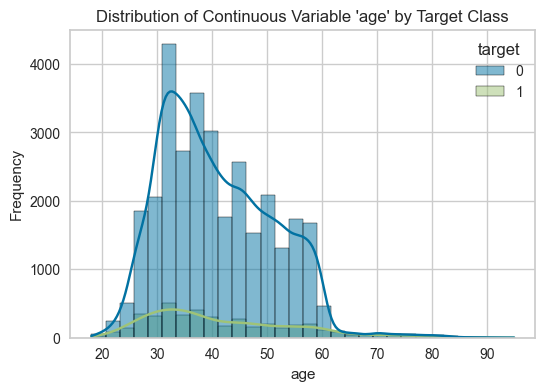

In [61]:
#1a. check the distribution of 'age' variable
## the Shapiro-Wilk & Kolmogorov-Smirnov tests suggest that 'age' is NOT NORMALLY DISTRIBUTED
## as the mean is greater than the median, distribution appears to be slightly right-skewed
## the histogram plot confirmed it is right skewed but there is no significant outlier

# Shapiro-Wilk test
shapiro_test_stat, shapiro_p_value = shapiro(Xy_train_val['target'])
print(f"\n Shapiro-Wilk Test: Test Statistic = {shapiro_test_stat}, p-value = {shapiro_p_value}")

# Kolmogorov-Smirnov test
ks_test_stat, ks_p_value = kstest(Xy_train_val['target'], 'norm')
print(f"Kolmogorov-Smirnov Test: Test Statistic = {ks_test_stat}, p-value = {ks_p_value}")

# find age the mean and median
mean_age = Xy_train_val['age'].mean()
median_age = Xy_train_val['age'].median()
mode_age = Xy_train_val['age'].mode()[0]
print(f"Mean age: {mean_age}, Median age: {median_age}, Mode age: {mode_age} \n")

# plot the relationship between age and target
plt.figure(figsize=(6, 4))
sns.histplot(x='age', hue='target', data=Xy_train_val, bins=30, kde=True)
plt.title('Distribution of Continuous Variable \'age\' by Target Class')
plt.xlabel('age')
plt.ylabel('Frequency');

In [62]:
#1b. check the variance of age for each class of target variable
## variance of age for each class of target variables differs, therefore bin

# compute the variances
variance_by_class0 = Xy_train_val.groupby('target')['age'].var()
print("Variance of age for each class of target:")
print(variance_by_class0)

Variance of age for each class of target:
target
0    104.017859
1    177.916442
Name: age, dtype: float64


In [63]:
#1c. bin the 'age' using kmeans in KBinsDiscretizer

# initialize KBinsDiscretizer
est0 = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')

# fit the bins to the Xy_train_val and transform to both Xy_train_val and Xy_test
Xy_train_val['age_binned'] = est0.fit_transform(Xy_train_val[['age']])
Xy_test['age_binned'] = est0.transform(Xy_test[['age']])

# view the 'age' bins
bin_edges0 = est0.bin_edges_[0]
for i in range(len(bin_edges0) - 1):
    print(f"Category {i}: From {bin_edges0[i]} to {bin_edges0[i + 1]}")

Category 0: From 18.0 to 35.13974197110912
Category 1: From 35.13974197110912 to 44.175616385092425
Category 2: From 44.175616385092425 to 53.00881092428085
Category 3: From 53.00881092428085 to 65.53449196699958
Category 4: From 65.53449196699958 to 95.0


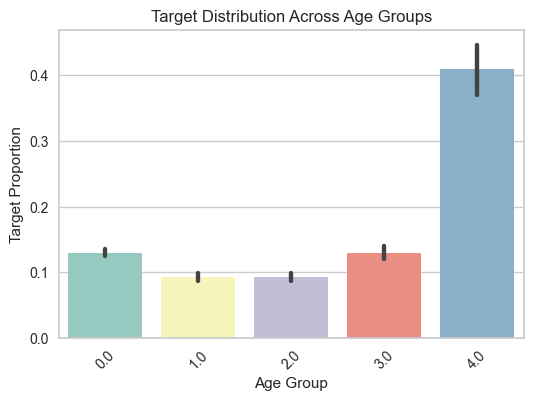

In [64]:
#1d. plot the distribution between age_binned groups and target

plt.figure(figsize=(6, 4))
sns.barplot(x='age_binned', y='target', data=Xy_train_val, palette='Set3')
plt.title('Target Distribution Across Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Target Proportion')
plt.xticks(rotation=45)
plt.show()

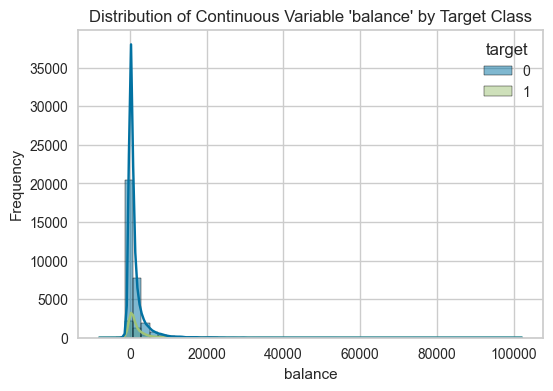

In [65]:
#2a. check the distribution of 'balance' variable w.r.t target using histogram

# plot the histogram
plt.figure(figsize=(6, 4))
sns.histplot(x='balance', hue='target', data=Xy_train_val, bins=50, kde=True)
plt.title('Distribution of Continuous Variable \'balance\' by Target Class')
plt.xlabel('balance')
plt.ylabel('Frequency');

In [66]:
## from the distribution, it seems there are outliers in the balance column
## further analyze the data to detect outlier using z-score
## if outliers are found, cap them by replacing the outliers with interquater boundary

In [67]:
#2b. detect the outlier rows

# compute the z_score for the 'balance' variable
z_scores1 = stats.zscore(Xy_train_val['balance'])

# set (3 standard deviations) as the threshold for outlier detection
bal_threshold = 3

# identify all rows with outliers
bal_outliers = Xy_train_val[abs(z_scores1) > bal_threshold]

# print total number of outliers in 'balance' variable
print(f'{len(bal_outliers)} rows with outliers!')

570 rows with outliers!


In [68]:
#2c. threshold capping for outliers
## replace the outliers with interquater boundary

# calculate the interquatile range of the training dataset
q1, q3 = Xy_train_val['balance'].quantile([0.25, .75])
bal_iqr = q3 - q1

# calculate the upper bound and lower bound of the training dataset
bal_upper = q3 + (bal_iqr * 1.5)
bal_lower = q1 - (bal_iqr * 1.5)

# replace the outliers with the upper/lower boundary in training dataset
Xy_train_val['balance_capped'] = Xy_train_val['balance']
Xy_train_val.loc[Xy_train_val['balance_capped'] >= bal_upper, 'balance_capped'] = bal_upper
Xy_train_val.loc[Xy_train_val['balance_capped'] <= bal_lower, 'balance_capped'] = bal_lower

# replace the outliers with the upper/lower boundary in testing dataset
Xy_test['balance_capped'] = Xy_test['balance']
Xy_test.loc[Xy_test['balance_capped'] >= bal_upper, 'balance_capped'] = bal_upper
Xy_test.loc[Xy_test['balance_capped'] <= bal_lower, 'balance_capped'] = bal_lower


# alternate way to apply the upper/lower bounds
# df['balance_capped'] = np.where(df.fare >= upper_bound, upper_bound, df.fare)
# df['balance_capped'] = df['balance'].apply(lambda x: upper if x>upper else x)

In [69]:
#2d. check the variance of capped balance for each class of target variable
variance_by_class1 = Xy_train_val.groupby('target')['balance_capped'].var()
print("Variance of balance for each class of target:")
print(variance_by_class1)

Variance of balance for each class of target:
target
0    1.341811e+06
1    1.549737e+06
Name: balance_capped, dtype: float64


In [70]:
#2e. bin the 'balance_capped' using uniform in KBinsDiscretizer

# initialize KBinsDiscretizer
est1 = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

# fit the bins to the Xy_train_val and transform to both Xy_train_val and Xy_test
Xy_train_val['balance_binned'] = est1.fit_transform(Xy_train_val[['balance_capped']])
Xy_test['balance_binned'] = est1.transform(Xy_test[['balance_capped']])

# view the 'balance' bins
bin_edges1 = est1.bin_edges_[0]
for i in range(len(bin_edges1) - 1):
    print(f"Bin {i}: From {bin_edges1[i]} to {bin_edges1[i + 1]}")

Bin 0: From -1953.375 to 22.0
Bin 1: From 22.0 to 271.0
Bin 2: From 271.0 to 703.0
Bin 3: From 703.0 to 1857.6000000000022
Bin 4: From 1857.6000000000022 to 3447.625


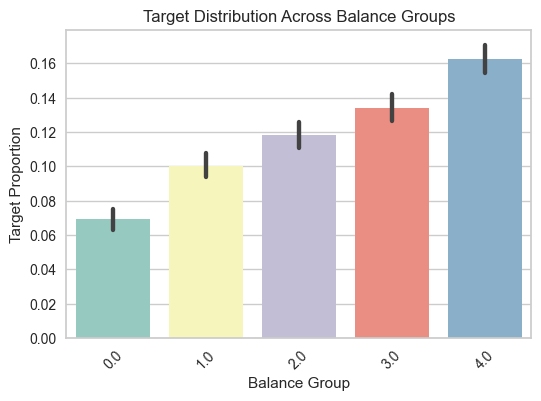

In [71]:
#2f. plot the distribution between balance_binned groups and target

plt.figure(figsize=(6, 4))
sns.barplot(x='balance_binned', y='target', data=Xy_train_val, palette='Set3')
plt.title('Target Distribution Across Balance Groups')
plt.xlabel('Balance Group')
plt.ylabel('Target Proportion')
plt.xticks(rotation=45)
plt.show()

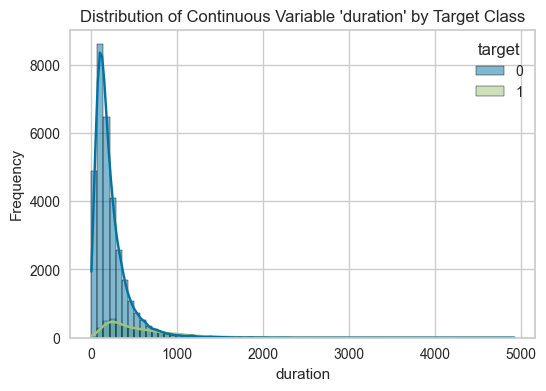

In [72]:
#3a. check the distribution of 'duration' variable w.r.t target using histogram
plt.figure(figsize=(6, 4))
sns.histplot(x='duration', hue='target', data=Xy_train_val, bins=70, kde=True)
plt.title('Distribution of Continuous Variable \'duration\' by Target Class')
plt.xlabel('duration')
plt.ylabel('Frequency');

In [73]:
#3b. detect the outlier rows using z-score

# compute the z_score for the 'balance' variable
z_scores2 = stats.zscore(Xy_train_val['duration'])

# set (3 standard deviations) as the threshold for outlier detection
dura_threshold = 3

# identify all rows with outliers
dura_outliers = Xy_train_val[abs(z_scores2) > dura_threshold]

# print total number of outliers in 'balance' variable
print(f'{len(dura_outliers)} rows with outliers!')

781 rows with outliers!


In [74]:
#3c. threshold capping for outliers
## replace the outliers with interquater boundary

# calculate the interquatile range of the training dataset
qq1, qq3 = Xy_train_val['duration'].quantile([0.25, .75])
dura_iqr = qq3 - qq1

# calculate the upper bound (only) for the training dataset
dura_upper = qq3 + (dura_iqr * 1.5)
dura_lower = qq1 - (dura_iqr * 1.5)

# replace the outliers with the upper/lower boundary in training dataset
Xy_train_val['duration_capped'] = Xy_train_val['duration']
Xy_train_val.loc[Xy_train_val['duration_capped'] >= bal_upper, 'duration_capped'] = dura_upper

# replace the outliers with the upper/lower boundary in testing dataset
Xy_test['duration_capped'] = Xy_test['duration']
Xy_test.loc[Xy_test['duration_capped'] >= bal_upper, 'duration_capped'] = dura_upper

In [75]:
#3b. check the variance of balance for each class of target variable
variance_by_class2 = Xy_train_val.groupby('target')['duration_capped'].var()
print("Variance of duration for each class of target:")
print(variance_by_class2)

Variance of duration for each class of target:
target
0     41139.134754
1    155997.645357
Name: duration_capped, dtype: float64


In [76]:
#3c. bin the 'duration' using uniform in KBinsDiscretizer
##  quantile is useful for handling outliers since extreme values are assigned to separate bins

# initialize KBinsDiscretizer
est2 = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='uniform')

# fit the bins to the Xy_train_val and transform to both Xy_train_val and Xy_test
Xy_train_val['duration_binned'] = est2.fit_transform(Xy_train_val[['duration_capped']])
Xy_test['duration_binned'] = est2.transform(Xy_test[['duration_capped']])

# view the 'balance' bins
bin_edges2 = est2.bin_edges_[0]
for i in range(len(bin_edges2) - 1):
    print(f"Bin {i}: From {bin_edges2[i]} to {bin_edges2[i + 1]}")

Bin 0: From 0.0 to 821.0
Bin 1: From 821.0 to 1642.0
Bin 2: From 1642.0 to 2463.0
Bin 3: From 2463.0 to 3284.0


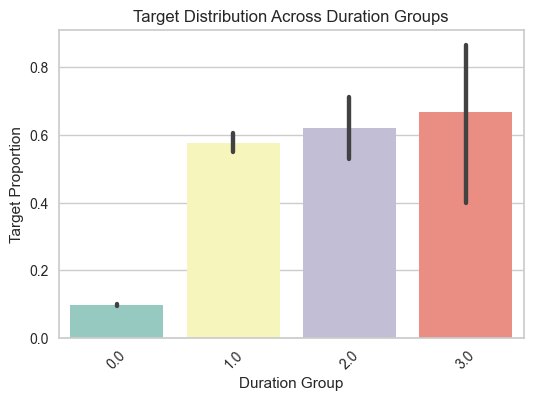

In [77]:
#3d. plot the distribution between balance_binned groups and target

plt.figure(figsize=(6, 4))
sns.barplot(x='duration_binned', y='target', data=Xy_train_val, palette='Set3')
plt.title('Target Distribution Across Duration Groups')
plt.xlabel('Duration Group')
plt.ylabel('Target Proportion')
plt.xticks(rotation=45)
plt.show()

<h2 
    align="center" 
    style="font-size: 40px; border-bottom: 2px solid black; border-top: 2px solid black; padding: 30px 0;">
    Feature Transformation II<br>
    <i>Encoding</i>
</h2>

<h2 style="font-size: 20px; margin: 20px 0; border-bottom: 2px solid black; padding: 15px 0;">
    <strong></i>
        1. Encode Categorical Variables - Binary
    </i></strong>
</h2>

In [78]:
#1a. select all columns with binary predictor

# extract all binary columns including boolean types from Xy df
binary_columns = Xy_train_val.columns[Xy_train_val.apply(lambda x: x.nunique() == 2 or x.dtype == 'bool')]

# drop target column!
binary_columns = binary_columns.drop(['target'])
print(f'list of binary columns: \n{list(binary_columns)}\n')

# view summary
summary_df = generate_column_summary(Xy_train_val[binary_columns], num_examples=3)
print(summary_df.sort_values(by='Unique_Count', ascending=True))

list of binary columns: 
['default', 'housing', 'loan', 'contact']

  Column_Name Unique_Count Data_Type               Examples
0     default            2    object              [no, yes]
1     housing            2    object              [yes, no]
2        loan            2    object              [yes, no]
3     contact            2    object  [cellular, telephone]


In [79]:
#1b. One Hot Encode (OHE) all binary data in both Xy_train_val & Xy_test

OHE_train = pd.get_dummies(Xy_train_val[binary_columns], drop_first=True, dtype=int)
OHE_test = pd.get_dummies(Xy_test[binary_columns], drop_first=True, dtype=int)

In [80]:
#1c. Concatenate the one-hot encoded DataFrames with the original DataFrames

Xy_train_val = pd.concat([Xy_train_val, OHE_train], axis=1)
Xy_test = pd.concat([Xy_test, OHE_test], axis=1)

<h2 style="font-size: 20px; margin: 20px 0; border-bottom: 2px solid black; padding: 15px 0;">
    <strong></i>
        2. Encode Categorical Variables - Nominal
    </i></strong>
</h2>

In [81]:
#1. view the summary of all categorical variables in Xy

# select categorical variables
categorical_columns = Xy_train_val.select_dtypes(include=['object', 'category'])
print('list of categorical dtypes:')
print(f'{list(categorical_columns.columns)}\n')

# select nominal categories for label encode
nominal_columns = ['job', 'marital', 'poutcome']
print(f'list of nominal_columns:\n {list(nominal_columns)}\n')

# view summary
summary_df = generate_column_summary(Xy_train_val[nominal_columns], num_examples=2)
print(summary_df.sort_values(by='Unique_Count', ascending=True))

list of categorical dtypes:
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

list of nominal_columns:
 ['job', 'marital', 'poutcome']

  Column_Name Unique_Count Data_Type                  Examples
1     marital            3    object       [divorced, married]
2    poutcome            3    object    [nonexistent, failure]
0         job           12    object  [technician, management]


In [82]:
#2a. apply OHE to nominal_columns

for col in nominal_columns:
    # initialize OneHotEncoder
    enc_job = OneHotEncoder(categories='auto', drop='first', sparse_output=False)
    
    # fit and transform the nominal_columns
    job_column_train = enc_job.fit_transform(Xy_train_val[[col]])
    job_column_test = enc_job.transform(Xy_test[[col]])

    # convert the sparse matrix output to a DataFrame 
    job_column_train = pd.DataFrame(job_column_train, columns=enc_job.get_feature_names_out([col]))
    job_column_test = pd.DataFrame(job_column_test, columns=enc_job.get_feature_names_out([col]))

    # concatenate the encoded DataFrame with the original DataFrame
    Xy_train_val = pd.concat([Xy_train_val.reset_index(drop=True), job_column_train], axis=1)
    Xy_test = pd.concat([Xy_test.reset_index(drop=True), job_column_test], axis=1)

<h2 style="font-size: 20px; margin: 20px 0; border-bottom: 2px solid black; padding: 15px 0;">
    <strong></i>
        3. Encode Categorical Variables - Ordinal
    </i></strong>
</h2>

In [83]:
#1a. list of categories that falls to ordinal category
ordinal_columns = ['education']
ordinal_columns

['education']

In [84]:
#2a. create order for education

# get the list of categories in education
edu_list = list(Xy['education'].unique())
print(f'unique education: {edu_list}')

# order the education list in increasing hierarchy
edu_order = ['unknown', 'primary', 'secondary', 'tertiary']
print(f'ordered education: {edu_order}')

unique education: ['tertiary', 'secondary', 'unknown', 'primary']
ordered education: ['unknown', 'primary', 'secondary', 'tertiary']


In [85]:
#2b. encode the education column

# initialize OrdinalEncoder with the specified order
encoder = OrdinalEncoder(categories=[edu_order], dtype=int)

# fit and transform the 'education' column
Xy_train_val['education_encoded'] = encoder.fit_transform(Xy_train_val[['education']])
Xy_test['education_encoded'] = encoder.transform(Xy_test[['education']])

In [86]:
#2c. view the various education count
Xy_train_val['education_encoded'].value_counts()

education_encoded
2    18556
3    10624
1     5492
0     1496
Name: count, dtype: int64

<h2 style="font-size: 20px; margin: 20px 0; border-bottom: 2px solid black; padding: 15px 0;">
    <strong></i>
        4. Encode Categorical Variables - Cyclic
    </i></strong>
</h2>

In [87]:
#1. Select cyclic feature columns
cyclic_columns = ['month', 'day_of_week']

In [88]:
#2a. map month names to numeric values

# create a map dictionary
month_mapping = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
                 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
# apply map
Xy_train_val['month'] = Xy_train_val['month'].map(month_mapping)
Xy_test['month'] = Xy_test['month'].map(month_mapping)

In [89]:
#2b. apply sine cosine transform

# temporal df for cyclic
XC_test = Xy_test.copy()
XC_train_val = Xy_train_val.copy()

# Create cyclic features (sin, cos) for each selected column
for col in cyclic_columns:
    # train df
    max_value1 = XC_train_val[col].max()
    XC_train_val[col+'_sin'] = np.sin((2*np.pi*XC_train_val[col])/max_value1)
    XC_train_val[col+'_cos'] = np.cos((2*np.pi*XC_train_val[col])/max_value1)
    # test df
    max_value2 = XC_test[col].max()
    XC_test[col+'_sin'] = np.sin((2*np.pi*XC_test[col])/max_value2)
    XC_test[col+'_cos'] = np.cos((2*np.pi*XC_test[col])/max_value2)
    

In [90]:
#2c. view sample cyclic features
print(XC_train_val[['month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos']].sample(5))

          month_sin     month_cos  day_of_week_sin  day_of_week_cos
26465 -1.000000e+00 -1.836970e-16         0.998717        -0.050649
15972  8.660254e-01 -5.000000e-01        -0.790776        -0.612106
35117  8.660254e-01 -5.000000e-01        -0.201299         0.979530
6803   1.224647e-16 -1.000000e+00         0.998717        -0.050649
7763   8.660254e-01  5.000000e-01         0.848644         0.528964


In [91]:
#2d. set df to original names to avoid confusion
Xy_train_val = XC_train_val
Xy_test = XC_test

In [92]:
#3. view overall df
Xy_train_val.sample(3)

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,...,job_unknown,marital_married,marital_single,poutcome_nonexistent,poutcome_success,education_encoded,month_sin,month_cos,day_of_week_sin,day_of_week_cos
26814,32,services,single,tertiary,no,-233,yes,no,cellular,28,...,0.0,0.0,1.0,1.0,0.0,3,0.500000,-0.866025,-0.571268,0.820763
18588,39,retired,single,primary,no,-79,no,no,cellular,9,...,0.0,0.0,1.0,1.0,0.0,1,0.500000,-0.866025,0.968077,-0.250653
8125,38,blue-collar,married,secondary,no,452,yes,no,cellular,9,...,0.0,1.0,0.0,1.0,0.0,2,0.866025,0.500000,0.968077,-0.250653


<h2 
    align="center" 
    style="font-size: 40px; border-bottom: 2px solid black; border-top: 2px solid black; padding: 30px 0;">
    Base Model II - Preprocessed
</h2>

<h2 style="font-size: 20px; margin: 20px 0; border-bottom: 2px solid black; padding: 15px 0;">
    <strong></i>
        1. Convert Data Types
    </i></strong>
</h2>

In [ ]:
#1. inspect if all datatypes in train and test sets fall withing Category, Integers, Float, or Date only

# manually inspect the training set
summary_df = generate_column_summary(Xy_train_val, num_examples=2)
print(f' train data summary:\n {summary_df}')

# manually inspect the training set
summary_df = generate_column_summary(Xy_train_val, num_examples=2)
#print(f' train data summary:\n {summary_df}')

In [94]:
#2. convert to apprioprate data type if needed

# example code
#Xy_train_val.target = Xy_train_val.target.astype('category')

<h2 style="font-size: 20px; margin: 20px 0; border-bottom: 2px solid black; padding: 15px 0;">
    <strong></i>
        2. Further Cleaning: Drop Unused Columns
    </i></strong>
</h2>

In [95]:
#1. drop all unused columns

# drop original continuous columns
XC_train_val = XC_train_val.drop(columns=['balance', 'duration'])
XC_test = XC_test.drop(columns=['balance', 'duration'])

# drop the original 'month', 'day_of_week'
XC_train_val = XC_train_val.drop(columns=cyclic_columns)
XC_test = XC_test.drop(columns=cyclic_columns)

# drop the original education column
Xy_train_val = Xy_train_val.drop(['education'], axis=1)
Xy_test = Xy_test.drop(['education'], axis=1)

# drop the original nominal_columns
Xy_train_val = Xy_train_val.drop(columns=nominal_columns)
Xy_test = Xy_test.drop(columns=nominal_columns)

# drop the original 'age','balance','duration' columns
Xy_train_val = Xy_train_val.drop(columns=to_bin)
Xy_test = Xy_test.drop(columns=to_bin)

# drop the original binary columns
Xy_train_val = Xy_train_val.drop(columns=binary_columns)
Xy_test = Xy_test.drop(columns=binary_columns)

In [96]:
#2. view sample df
Xy_train_val.sample(1)

,day_of_week,month,campaign,pdays,previous,target,age_binned,balance_capped,balance_binned,duration_capped,...,job_unknown,marital_married,marital_single,poutcome_nonexistent,poutcome_success,education_encoded,month_sin,month_cos,day_of_week_sin,day_of_week_cos
29973,18,7,1,-1,0,0,2.0,0.0,0.0,115.0,...,0.0,1.0,0.0,1.0,0.0,2,-0.5,-0.866025,-0.485302,-0.874347


<h2 style="font-size: 20px; margin: 20px 0; border-bottom: 2px solid black; padding: 15px 0;">
    <strong></i>
        3. Label Data - Training Set
    </i></strong>
</h2>

In [97]:
#1. create a copy of original data

Xy_train_val0 = Xy_train_val.copy()

In [98]:
#2. seperate X and y for training data

X_train_val0 = Xy_train_val0.drop(columns='target')
y_train_val0 = Xy_train_val0['target']

<h2 style="font-size: 20px; margin: 20px 0; border-bottom: 2px solid black; padding: 15px 0;">
    <strong></i>
        3. Stratified K-Fold Cross Validation with SMOTEENN
    </i></strong>
</h2>

In [99]:
#1a. apply stratified k-fold CV with SMOTTENN

f_scores = []
accuracies = []
auc_scores = []

skf0 = StratifiedKFold(n_splits=5, random_state=1, shuffle=True) # initialize skfold

for train_index, val_index in skf0.split(X_train_val0, y_train_val0):
    # split data into training and validation sets
    X_train0, X_val0 = X_train_val0.iloc[train_index], X_train_val0.iloc[val_index]
    y_train0, y_val0 = y_train_val0.iloc[train_index], y_train_val0.iloc[val_index]
    
    # handle inbalance in training set using SMOTEENN
    smote_enn = SMOTEENN(random_state=1)
    X_resampled, y_resampled = smote_enn.fit_resample(X_train0, y_train0)

    # train the model on resampled data
    model_1 = RandomForestClassifier(n_estimators=200, random_state=1)
    model_1.fit(X_resampled, y_resampled)

    # make predictions on validation data
    y_pred_1 = model_1.predict(X_val0)

    # cross-validated performance
    f_score = f1_score(y_val0, y_pred_1)
    accuracy = accuracy_score(y_val0, y_pred_1)
    auc_score = roc_auc_score(y_val0, y_pred_1)
    f_scores.append(f_score)
    accuracies.append(accuracy)
    auc_scores.append(auc_score)

In [100]:
#2.  calculate the mean and stdv of AUC, F1, and accuracy scores from RF using CV

# calculate the mean and standard deviation of auc_scores
mean_auc_scores = np.mean(auc_scores)
std_auc_scores = np.std(auc_scores)

# calculate the mean and standard deviation of f_scores
mean_f_scores = np.mean(f_scores)
std_f_scores = np.std(f_scores)

# Calculate the mean and standard deviation of accuracies
mean_accuracies = np.mean(accuracies)
std_accuracies = np.std(accuracies)

# Print mean and standard deviation values
print(f"Mean AUC Scores: {mean_auc_scores}, Std AUC Scores: {std_auc_scores}")
print(f"Mean F1 Scores: {mean_f_scores}, Std F1 Scores: {std_f_scores}")
print(f"Mean Accuracies: {mean_accuracies}, Std Accuracies: {std_accuracies}")


Mean AUC Scores: 0.8164053202093806, Std AUC Scores: 0.01300424252237775
Mean F1 Scores: 0.5932938876783731, Std F1 Scores: 0.014353849875213444
Mean Accuracies: 0.8830735132852869, Std Accuracies: 0.004088646263932842


In [104]:
#3. plot the CV Accuracy for Base Model

bp.output_notebook()
cv_range = list(range(1,11))

# create plot with a log axis type
p = bp.figure(title = 'CV Accuracy for Base Model', width=600, height=300)

p.line(cv_range, accuracies, line_width=2)
p.circle(cv_range, accuracies, fill_color="red", size=8)
p.title.text_font_size = '16pt'
p.yaxis.axis_label_text_font_size = "14pt"
p.xaxis.axis_label_text_font_size = "14pt"

bp.show(p)

Loading BokehJS ...

<h2 
    align="center" 
    style="font-size: 40px; border-bottom: 2px solid black; border-top: 2px solid black; padding: 30px 0;">
    Feature Engineering
</h2>

<h2 style="font-size: 20px; margin: 20px 0; border-bottom: 2px solid black; padding: 15px 0;">
    <strong></i>
        1. Combine Features
    </i></strong>
</h2>

In [105]:
#1. combine the total number of contacts made before and during campaign 
## 'previous' is the numb of contacts before campaign & 'campaign' is the numb of contacts during campaign

# for train dataset
Xy_train_val['campaign_total'] = Xy_train_val['campaign'] + Xy_train_val['previous']

# for test dataset
Xy_test['campaign_total'] = Xy_test['campaign'] + Xy_test['previous']

# drop the original columns
Xy_train_val = Xy_train_val.drop(columns=['campaign', 'previous'])
Xy_test = Xy_test.drop(columns=['campaign', 'previous'])

<h2 
    align="center" 
    style="font-size: 40px; border-bottom: 2px solid black; border-top: 2px solid black; padding: 30px 0;">
    Hyper-parameter Tuning
</h2>

<h2 style="font-size: 20px; margin: 20px 0; border-bottom: 2px solid black; padding: 15px 0;">
    <strong></i>
        1. Initialize Data and Tuning Function
    </i></strong>
</h2>

In [106]:
#1. initialize datasets

# create a copy of original data
Xy_train_val1 = Xy_train_val.copy()

# seperate X and y for training data
X_train_val1 = Xy_train_val1.drop(columns='target')
y_train_val1 = Xy_train_val1['target']

In [107]:
#2. function for hyper-parameter tuning

def perform_random_search(X, y, classifier, param_grid):
    '''
    Perform randomized search for hyperparameter optimization of a classifier
    it uses SMOTEENN, StratifiedKFold, and f1_score
    '''

    ## initialize parameters
    # SMOTEENN for imbalance
    smote_enn = SMOTEENN(random_state=1)
    # scoring metrics
    scoring = make_scorer(f1_score)
    # cross-validation with stratifiedKFold
    skf1 = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
    
    # pipeline for classifier algorithm with SMOTEENN
    pipeline = make_pipeline(smote_enn, classifier)

    # parameter grid for pipeline: loop through the parameters defined in the param_grid
    param_grid_pipeline = {f'{classifier.__class__.__name__.lower()}__{key}': value for key, value in param_grid.items()}

    # initialize RandomizedSearchCV for classifier algorithm
    random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_grid_pipeline,
                                       scoring=scoring, refit='f1', cv=skf1, n_iter=25, random_state=1, n_jobs=-1)

    # fit RandomizedSearchCV for the algorithm
    random_search.fit(X, y)
    
    # get results, best score and best parameters
    best_score = random_search.best_score_
    best_params = random_search.best_params_
    random_search_results = random_search.cv_results_

    return best_score, best_params, random_search_results

<h2 style="font-size: 20px; margin: 20px 0; border-bottom: 2px solid black; padding: 15px 0;">
    <strong></i>
        2. Tuning RandomForestClassifier - Ensemble method | Bagging
    </i></strong>
</h2>

In [108]:
#1. tuning RandomForestClassifier

# initialize rf
rf_class = RandomForestClassifier(random_state=1)

# parameter grid for rf
rf_grid = {'n_estimators': np.arange(98, 103),
                 'max_depth': np.arange(3, 8)}

# get best f1_score and best parameters for rf
rf_score, rf_param, rf_results = perform_random_search(X_train_val1, y_train_val1, rf_class, rf_grid)
print(f"Best Score: {rf_score}\nBest Parameters: {rf_param}")

# rf_tuned = RandomForestClassifier(max_depth=7, n_estimators=99)
# Best Score: 0.5462730226358397

Best Score: 0.5462730226358397
Best Parameters: {'randomforestclassifier__n_estimators': 99, 'randomforestclassifier__max_depth': 7}


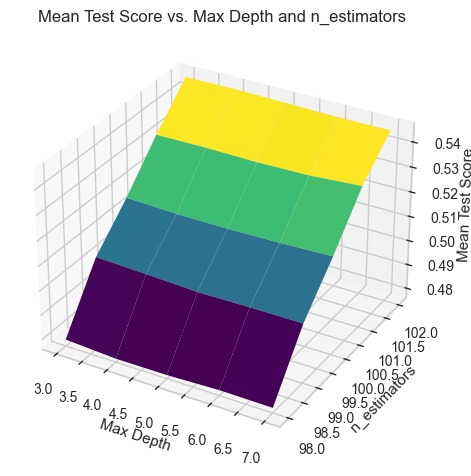

In [109]:
#2. 3D plot of Average F1 vs. Max Depth and n_estimators

# extract rf results from RandomizedSearchCV
max_depth_values = rf_grid['max_depth']
n_estimators_values = rf_grid['n_estimators']
average_f1 = rf_results['mean_test_score'].reshape(len(n_estimators_values), len(max_depth_values)).T
average_f1 = average_f1.T

# create meshgrid for max_depth and n_estimators
max_depth_mesh, n_estimators_mesh = np.meshgrid(max_depth_values, n_estimators_values)

# create a 3D surface plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(max_depth_mesh, n_estimators_mesh, average_f1, cmap='viridis')
ax.set_xlabel('Max Depth')
ax.set_ylabel('n_estimators')
ax.set_zlabel('Mean Test Score')
ax.set_title('Mean Test Score vs. Max Depth and n_estimators');

<h2 style="font-size: 20px; margin: 20px 0; border-bottom: 2px solid black; padding: 15px 0;">
    <strong></i>
        3. Tuning XGBClassifier - Ensemble method | Boosting
    </i></strong>
</h2>

In [110]:
#1. tuning XGBClassifier

# initialize xgboost
xgb_class = xgb.XGBClassifier(random_state=1)

# parameter grid for xgboost
xgb_grid = {'n_estimators': np.arange(50, 301, 50),
            'max_depth': np.arange(3, 8),
            'learning_rate': [0.01, 0.05, 0.1, 0.2]}

# get best fi_score and best parameters
xgb_score, xgb_param, xgb_results = perform_random_search(X_train_val1, y_train_val1, xgb_class, xgb_grid)
print(f"Best Score: {xgb_score}\nBest Parameters: {xgb_param}")

# xgb_tuned = xgb.XGBClassifier(max_depth=6,n_estimators=200,learning_rate=0.1)
# Best Score: 0.599771645041814

Best Score: 0.599771645041814
Best Parameters: {'xgbclassifier__n_estimators': 200, 'xgbclassifier__max_depth': 6, 'xgbclassifier__learning_rate': 0.1}


<h2 style="font-size: 20px; margin: 20px 0; border-bottom: 2px solid black; padding: 15px 0;">
    <strong></i>
        4. Tuning Base Model & Meta Models - Ensemble method | Stacking
    </i></strong>
</h2>

In [111]:
##NB: because of computational cost, the hyper-parameters of each stacked models are tuned seperately

In [114]:
#1a. tuning KNeighborsClassifier

# initialize knn
np.random.seed(1)
knn_class = KNeighborsClassifier()

# parameter grid for knn
knn_grid = {'n_neighbors': np.arange(3, 21, 2),
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

# get best fi_score and best parameters
knn_score, knn_param, knn__results = perform_random_search(X_train_val1, y_train_val1, knn_class, knn_grid)
print(f"Best Score: {knn_score}\nBest Parameters: {knn_param}")

# knn_tuned = KNeighborsClassifier(n_neighbors=19, weights='distance', algorithm='kd_tree')
# Best Score: 0.3954149608723777

Best Score: 0.3954149608723777
Best Parameters: {'kneighborsclassifier__weights': 'distance', 'kneighborsclassifier__n_neighbors': 19, 'kneighborsclassifier__algorithm': 'kd_tree'}


In [115]:
#1b. tuning RidgeClassifier

# initialize ridge
rg_class = RidgeClassifier(random_state=1)

# parameter grid for ridge
rg_grid = {'alpha': [0.1, 1, 10],
           'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

# get best fi_score and best parameters
rg_score, rg_param, rg_results = perform_random_search(X_train_val1, y_train_val1, rg_class, rg_grid)
print(f"Best Score: {rg_score}\nBest Parameters: {rg_param}")

# rg_tuned = RidgeClassifier(solver='sparse_cg',alpha=10)
# Best Score: 0.4888169897574219

2024-03-28 00:54:01,684 - INFO     - Executing shutdown due to inactivity...
2024-03-28 00:54:31,012 - INFO     - Executing shutdown...
2024-03-28 00:54:31,015 - INFO     - Not running with the Werkzeug Server, exiting by searching gc for BaseWSGIServer


Best Score: 0.4888169897574219
Best Parameters: {'ridgeclassifier__solver': 'sparse_cg', 'ridgeclassifier__alpha': 10}


In [116]:
#1c. tuning Logistic Regression

# initialize lr
np.random.seed(1)
lr_class = LogisticRegression()

# parameter grid for lr
lr_grid = {'penalty': ['l1', 'l2'],
                 'C': [0.001, 0.01, 0.1, 1, 10, 100],
                 'solver': ['liblinear', 'saga']}

# get best fi_score and best parameters
lr_score, lr_param, lr_results = perform_random_search(X_train_val1, y_train_val1, lr_class, lr_grid)
print(f"Best Score: {lr_score}\nBest Parameters: {lr_param}")

# lr_tuned = LogisticRegression(penalty='l1', C=0.1, solver='liblinear')
# Best Score: 0.49691188711678425

Best Score: 0.49691188711678425
Best Parameters: {'logisticregression__solver': 'liblinear', 'logisticregression__penalty': 'l1', 'logisticregression__C': 0.1}


<h2 
    align="center" 
    style="font-size: 40px; border-bottom: 2px solid black; border-top: 2px solid black; padding: 30px 0;">
    Evaluate Model Performance
</h2>

<h2 style="font-size: 20px; margin: 20px 0; border-bottom: 2px solid black; padding: 15px 0;">
    <strong></i>
        1. Label Training and Testing Datasets
    </i></strong>
</h2>

In [117]:
#1. initialize datasets

# copy of preprocessed training and test data
Xy_train_val1 = Xy_train_val.copy()
Xy_test1 = Xy_test.copy()

# seperate X and y for training
X_train_val1 = Xy_train_val1.drop(columns='target')
y_train_val1 = Xy_train_val1['target']

# seperate X and y for test data
X_test1 = Xy_test1.drop(columns='target')
y_test1 = Xy_test1['target']

<h2 style="font-size: 20px; margin: 20px 0; border-bottom: 2px solid black; padding: 15px 0;">
    <strong></i>
        2. Initialize Models with Tuned Hyper-parameters
    </i></strong>
</h2>

In [118]:
#1. models initialization

# apply the optimum hyper-parameters to the models
np.random.seed(1)
lr_tuned = LogisticRegression(penalty='l1', C=0.1, solver='liblinear')
rg_tuned = RidgeClassifier(solver='sparse_cg',alpha=10, random_state=1)
knn_tuned = KNeighborsClassifier(n_neighbors=19, weights='distance', algorithm='kd_tree')
xgb_tuned = xgb.XGBClassifier(max_depth=6,n_estimators=200,learning_rate=0.1, random_state=1)
rf_tuned = RandomForestClassifier(max_depth=7, n_estimators=99, random_state=1)

<h2 style="font-size: 20px; margin: 20px 0; border-bottom: 2px solid black; padding: 15px 0;">
    <strong></i>
        3. Retrain the Models with Full Training Dataset & Predict
    </i></strong>
</h2>

In [134]:
#1. train and predict with RandomForestClassifier

# train rf model
rf_tuned.fit(X_train_val1, y_train_val1)

# make predictions
rf_predict = rf_tuned.predict(X_test1)
rf_predict_proba = rf_tuned.predict_proba(X_test1)[:, 1]
FPR_rf_test, TPR_rf_test, _ = roc_curve(y_test1, rf_predict_proba) #for roc curve


# calculate scores
rf_accuracy = accuracy_score(y_test1, rf_predict)
rf_f1 = f1_score(y_test1, rf_predict)
rf_auc = roc_auc_score(y_test1, rf_predict)

# print scores
print(f"Accuracy: {rf_accuracy}, F1 Score: {rf_f1}, AUC Score: {rf_auc}")
rf = [rf_accuracy, rf_f1, rf_auc]

Accuracy: 0.8997014265177485, F1 Score: 0.37318590186592954, AUC Score: 0.6201477723472532


In [135]:
#2. train and predict with XGBClassifier

# train xgb model
xgb_tuned.fit(X_train_val1, y_train_val1)

# make predictions
xgb_predict = xgb_tuned.predict(X_test1)
xgb_predict_proba = xgb_tuned.predict_proba(X_test1)[:, 1]
FPR_xgb_test, TPR_xgb_test, _ = roc_curve(y_test1, xgb_predict_proba) #for roc curve

# calculate scores
xgb_accuracy = accuracy_score(y_test1, xgb_predict)
xgb_f1 = f1_score(y_test1, xgb_predict)
xgb_auc = roc_auc_score(y_test1, xgb_predict)

# print scores
print(f"Accuracy: {xgb_accuracy}, F1 Score: {xgb_f1}, AUC Score: {xgb_auc}")
xgb = [xgb_accuracy, xgb_f1, xgb_auc]

Accuracy: 0.9083268826716797, F1 Score: 0.5550187869028449, AUC Score: 0.7262951090951488


In [136]:
#3. train and predict with KNeighborsClassifier

# train knn model
knn_tuned.fit(X_train_val1, y_train_val1)

# make predictions
knn_predict = knn_tuned.predict(X_test1)
knn_predict_proba = knn_tuned.predict_proba(X_test1)[:, 1]
FPR_knn_test, TPR_knn_test, _ = roc_curve(y_test1, knn_predict_proba) #for roc curve

# calculate scores
knn_accuracy = accuracy_score(y_test1, knn_predict)
knn_f1 = f1_score(y_test1, knn_predict)
knn_auc = roc_auc_score(y_test1, knn_predict)

# print scores
print(f"Accuracy: {knn_accuracy}, F1 Score: {knn_f1}, AUC Score: {knn_auc}")
knn = [knn_accuracy, knn_f1, knn_auc]

Accuracy: 0.8856574145748093, F1 Score: 0.3188405797101449, AUC Score: 0.6007161348132664


In [138]:
#4. train and predict with RidgeClassifier

# train rg model
rg_tuned.fit(X_train_val1, y_train_val1)

# make predictions
rg_predict = rg_tuned.predict(X_test1) ##no roc curve - does not support probability estimates

# calculate scores
rg_accuracy = accuracy_score(y_test1, rg_predict)
rg_f1 = f1_score(y_test1, rg_predict)
rg_auc = roc_auc_score(y_test1, rg_predict)

# print scores
print(f"Accuracy: {rg_accuracy}, F1 Score: {rg_f1}, AUC Score: {rg_auc}")
rg = [rg_accuracy, rg_f1, rg_auc]

Accuracy: 0.8946146190423532, F1 Score: 0.35738368172623064, AUC Score: 0.6152175096737384


In [139]:
#5. train and predict with LogisticRegression

# train lr model
lr_tuned.fit(X_train_val1, y_train_val1)

# make predictions
lr_predict = rg_tuned.predict(X_test1)
lr_predict_proba = lr_tuned.predict_proba(X_test1)[:, 1]
FPR_lr_test, TPR_lr_test, _ = roc_curve(y_test1, lr_predict_proba) #for roc curve

# calculate scores
lr_accuracy = accuracy_score(y_test1, lr_predict)
lr_f1 = f1_score(y_test1, lr_predict)
lr_auc = roc_auc_score(y_test1, lr_predict)

# print scores
print(f"Accuracy: {lr_accuracy}, F1 Score: {lr_f1}, AUC Score: {lr_auc}")
lr = [lr_accuracy, lr_f1, lr_auc]

Accuracy: 0.8946146190423532, F1 Score: 0.35738368172623064, AUC Score: 0.6152175096737384


In [140]:
#6. train and predict with stacked models

# define base models
base_models = [('xgb', xgb_tuned), ('rf', rf_tuned)]

# define meta-model
meta_model = lr_tuned

# initialize stacking classifier
stacking_classifier = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# train stacked model
stacking_classifier.fit(X_train_val1, y_train_val1)

# make predictions
stack_predict = stacking_classifier.predict(X_test1)
stack_predict_proba = stacking_classifier.predict_proba(X_test1)[:, 1]
FPR_stack_test, TPR_stack_test, _ = roc_curve(y_test1, stack_predict_proba) #for roc curve

# calculate scores
st_accuracy = accuracy_score(y_test1, stack_predict)
st_f1 = f1_score(y_test1, stack_predict)
st_auc = roc_auc_score(y_test1, stack_predict)

# print scores
print(f"Accuracy: {st_accuracy}, F1 Score: {st_f1}, AUC Score: {st_auc}")
stacked = [st_accuracy, st_f1, st_auc]

Accuracy: 0.9062258100187991, F1 Score: 0.5246636771300448, AUC Score: 0.7050167315133645


In [125]:
#7a. compare the results in df

# lists of models
model_results = [rf, xgb, knn, rg, lr, stacked]

# create DataFrame
result_df = pd.DataFrame(model_results, columns=["Accuracy", "F1 Score", "AUC Score"], \
                         index=["rf", "xgb", "knn", "rg", "lr", "Stacked"]).rename_axis('Model')

# sort by F1 Score
result_df = result_df.sort_values(by="F1 Score", ascending=False)
print(result_df)

         Accuracy  F1 Score  AUC Score
Model                                 
xgb      0.908327  0.555019   0.726295
Stacked  0.906226  0.524664   0.705017
rf       0.899701  0.373186   0.620148
rg       0.894615  0.357384   0.615218
lr       0.894615  0.357384   0.615218
knn      0.885657  0.318841   0.600716


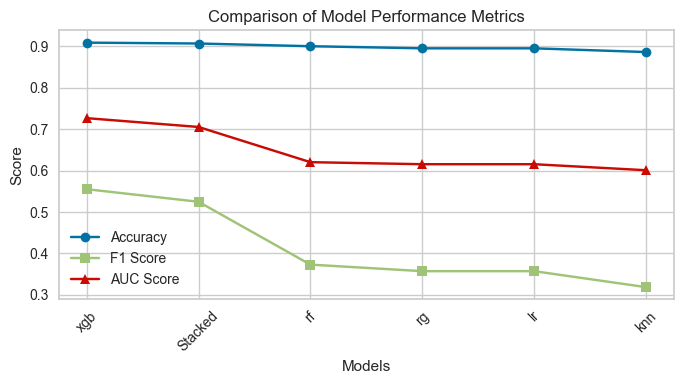

In [126]:
#7b. plot the comparison

plt.figure(figsize=(7, 4))
plt.plot(result_df.index, result_df['Accuracy'], marker='o', label='Accuracy')
plt.plot(result_df.index, result_df['F1 Score'], marker='s', label='F1 Score')
plt.plot(result_df.index, result_df['AUC Score'], marker='^', label='AUC Score')

plt.title('Comparison of Model Performance Metrics')
plt.xlabel('Models')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

<h2 
    align="center" 
    style="font-size: 40px; border-bottom: 2px solid black; border-top: 2px solid black; padding: 30px 0;">
    Feature Importance Analysis of Best Model
</h2>

In [127]:
# to gain insights into which features are most predictive of the target variable
# to help in feature selection, identifying key drivers of the outcome
# to understand the underlying patterns in the data

poutcome_success    0.308622
housing_yes         0.089317
duration_capped     0.085932
month_sin           0.057387
month_cos           0.031843
month               0.031487
job_blue-collar     0.024756
day_of_week         0.024751
job_student         0.024608
loan_yes            0.024018
dtype: float32


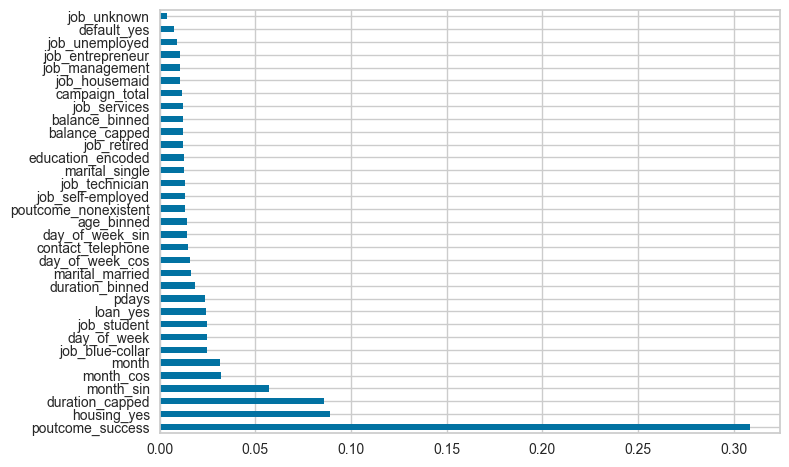

In [131]:
# get the feature importance of best performing models
xgb_feature = pd.Series(xgb_tuned.feature_importances_, index=X_train_val1.columns).sort_values(ascending=False)
print(xgb_feature.head(10))

# plot the feature importance
xgb_feature.plot(kind='barh');


In [ ]:
## for this analysis, all the features will be used since there are lots of features in similar range

<h2 
    align="center" 
    style="font-size: 40px; border-bottom: 2px solid black; border-top: 2px solid black; padding: 30px 0;">
    Model Interpretation/Evaluation
</h2>

<h2 style="font-size: 20px; margin: 20px 0; border-bottom: 2px solid black; padding: 15px 0;">
    <strong></i>
        1. ROC-AUC Curve
    </i></strong>
</h2>

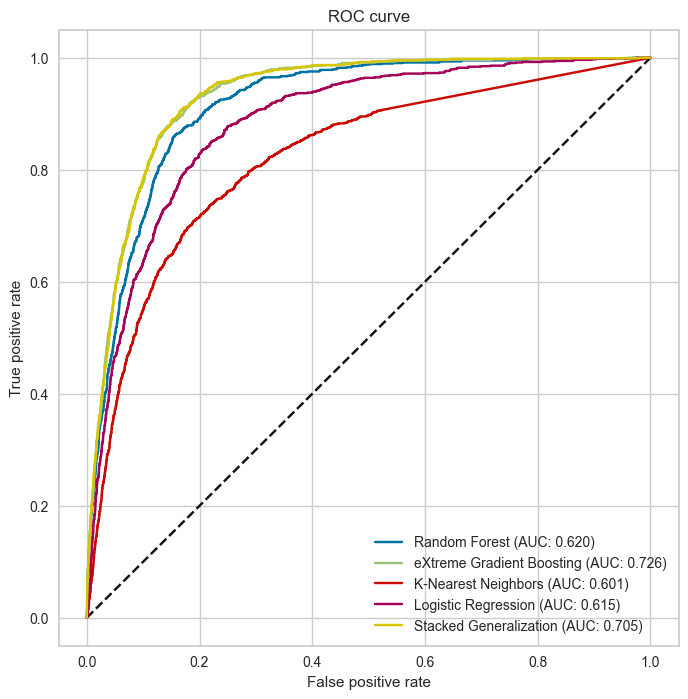

In [144]:
# ROC-AUC curve for probability estimating algorithms

# plot the ROC curve
plt.figure(1, figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(FPR_rf_test, TPR_rf_test, label='Random Forest (AUC: {0:.3f})'.format(rf_auc))
plt.plot(FPR_xgb_test, TPR_xgb_test, label='eXtreme Gradient Boosting (AUC: {0:.3f})'.format(xgb_auc))
plt.plot(FPR_knn_test, TPR_knn_test, label='K-Nearest Neighbors (AUC: {0:.3f})'.format(knn_auc))
plt.plot(FPR_lr_test, TPR_lr_test, label='Logistic Regression (AUC: {0:.3f})'.format(lr_auc))
plt.plot(FPR_stack_test, TPR_stack_test, label='Stacked Generalization (AUC: {0:.3f})'.format(st_auc))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best');

<h2 style="font-size: 20px; margin: 20px 0; border-bottom: 2px solid black; padding: 15px 0;">
    <strong></i>
        2. Model Evaluation using Lift and Gain Analysis | Lift and Gain Charts
        <a href='https://varshasaini.in/model-evaluation-using-lift-and-gain-analysis-lift-and-gain-charts/'> [ref] </a>
    </i></strong>
</h2>

   Decile  Cases  Responses  CumulativeResponses  %of_Events   Gain  lift
0       1    905        565                  565       53.40  53.40  5.34
1       2    904        310                  875       29.30  82.70  4.14
2       3    904        117                  992       11.06  93.76  3.13
3       4    904         42                 1034        3.97  97.73  2.44
4       5    904         10                 1044        0.95  98.68  1.97
5       6    905          7                 1051        0.66  99.34  1.66
6       7    904          3                 1054        0.28  99.62  1.42
7       8    904          1                 1055        0.09  99.71  1.25
8       9    904          0                 1055        0.00  99.71  1.11
9      10    905          3                 1058        0.28  99.99  1.00

In decile 1, the lift is 5.34:
this means that if we use the above logistic regression model then by selecting just 20% of the data,
we can find the actual churned customers 5.34 times 

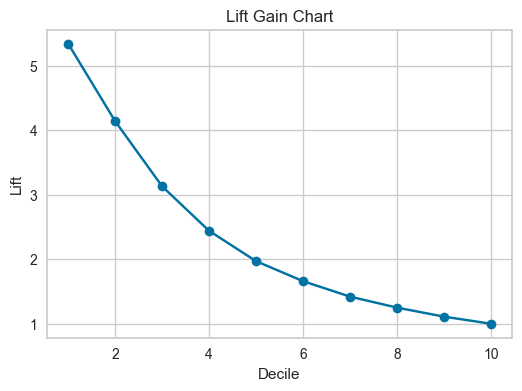

In [133]:
# Lift and Gain Analysis
# create a new DataFrame or add to X_test if you wish to keep everything together
X_test_with_prob = X_test1.copy()

# predict probabilities with the original features used for training
X_test_with_prob['Prob'] = xgb_tuned.predict_proba(X_test1[xgb_tuned.feature_names_in_])[:, 1]

# sort X_test_with_prob by 'Prob' and proceed with your analysis
X_test_with_prob = X_test_with_prob.sort_values(by='Prob', ascending=False)

# assign deciles
X_test_with_prob['Decile'] = pd.qcut(X_test_with_prob['Prob'], 10, labels=[i for i in range(10, 0, -1)])

# add your 'Subscribe' column
X_test_with_prob['Subscribe'] = y_test1

# compute the number of responses in each decile
response = pd.crosstab(X_test_with_prob['Decile'], X_test_with_prob['Subscribe'])[1].reset_index().rename(columns={1: 'Responses'})

# compute the number of cases in each decile
lift_gain = X_test_with_prob['Decile'].value_counts().reset_index().rename(columns={'count':'Cases'})

# merge to combine the responses with the total cases
lift_gain = pd.merge(lift_gain, response, on='Decile').sort_values(by='Decile', ascending=False).reset_index(drop=True)

# calculate the cumulative
lift_gain['CumulativeResponses'] = lift_gain['Responses'].cumsum()

# calculate the percentage of positive in each decile compared to the total number of responses
lift_gain['%of_Events'] = np.round(((lift_gain['Responses']/lift_gain['Responses'].sum())*100),2)

# calculate the Gain in each decile
lift_gain['Gain'] = lift_gain['%of_Events'].cumsum()

# convert Decile column to int
lift_gain['Decile']=lift_gain['Decile'].astype('int')

# calculate lift
lift_gain['lift']=np.round((lift_gain['Gain']/(lift_gain['Decile']*10)),2)

# display the resulting DataFrame
print(lift_gain)

# interpretation
print(f'\nIn decile {lift_gain.iloc[0,0]}, the lift is {lift_gain.iloc[0,-1]}:\n\
this means that if we use the above logistic regression model then by selecting just 20% of the data,\n\
we can find the actual churned customers {lift_gain.iloc[0,-1]} times more than if we randomly select any model')

# Lift and Gain Charts
# Plot the lift gain chart
plt.figure(figsize=(6, 4))
plt.plot(lift_gain['Decile'], lift_gain['lift'], marker='o', linestyle='-')
plt.title('Lift Gain Chart')
plt.xlabel('Decile')
plt.ylabel('Lift')
plt.grid(True)

<h2 style="font-size: 20px; margin: 20px 0; border-bottom: 2px solid black; padding: 15px 0;">
    <strong></i>
        2. LIME Methodology
    </i></strong>
</h2>

In [151]:
# use lime to explain the best performing algorithm - xgb_tuned

# initialize a LIME explainer
explainer = LimeTabularExplainer(training_data=np.array(X_train_val1),
                                 feature_names=X_train_val1.columns,
                                 class_names=['Accept', 'Reject'],
                                 mode='classification')

# choose multiple instances to explain
instance_indices = [7]

# loop through each instance index
for instance_index in instance_indices:
    instance = X_test1.iloc[instance_index] # get instances

    # generate LIME explanation for this instance
    exp = explainer.explain_instance(data_row=instance, 
                                     predict_fn=xgb_tuned.predict_proba, # predict_proba for classification algorithm
                                     num_features=len(X_train_val1.columns)) # no. of features to include in the explanation

    # visualize the explanation
    exp.show_in_notebook(show_table=True, show_all=False)

<h2 style="font-size: 20px; margin: 20px 0; border-bottom: 2px solid black; padding: 15px 0;">
    <strong></i>
        3. SHAP Methodology
    </i></strong>
</h2>

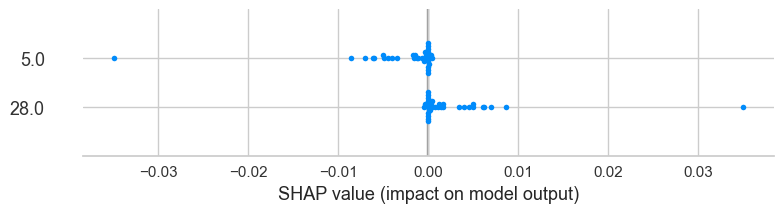

In [157]:
# xgb_tuned method explained with SHAP

# use SHAP to explain best performing algorithm
explainer = shap.TreeExplainer(rf_tuned)
shap_values = explainer.shap_values(instance)

# summary plot for feature importance
shap.summary_plot(shap_values, instance)

<h2 
    align="center" 
    style="font-size: 40px; border-bottom: 2px solid black; border-top: 2px solid black; padding: 30px 0;">
    Model Deployment
</h2>

In [ ]:
# deploy to server

# concatenate the entire dataset
X_all = pd.concat([X_train_val1, X_test1], ignore_index=True)
y_all =pd.concat([y_train_val1, y_test1], ignore_index=True)

# save the model and data processing steps in pipeline
pipe = make_pipeline(['preprocessing_steps', xgb_tuned])
pipe.fit(X_all, y_all)
dump(pipe, 'model.joblib')

# load deployed model
model = load('model.joblib')

# extract new data
new_data = extract('newdata.data')

# transform new data and predict
model.predict(new_data)